# Polarization behaviors on Twitter : holistic analysis

In this notebook, the following steps are performed:
* Computation of studied polarization factors (normalized entropy)
* Computation of polarization scores, using the GRAIL metric
* Identification of behavioral classes, using the k-means algorithm
* Characterization of behavioral classes, using hierarchial regression

# Libraries import

In [22]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from scipy.stats import entropy
from tqdm import tnrange, tqdm_notebook
import itertools
import statsmodels.api as sm
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import davies_bouldin_score

# Data import

In [2]:
#Vaccine debate 
edges = pd.read_csv('data/interactions_vaccine_debate.csv', index_col=0)
factors_data = pd.read_csv('data/indicators_vaccine_debate.csv', index_col=0)

#Ukraine conflict debate
# edges = pd.read_csv('data/interactions_ukraine_debate.csv', index_col=0)
# factors_data = pd.read_csv('data/indicators_ukraine_debate.csv', index_col=0)

In [3]:
edges.head()

,Source,Target,Timeset,Side
0,S0V,E0V,2022-07-30,provax
1,S0V,E0V,2022-07-30,provax
2,S0V,E1V,2022-07-27,provax
3,S0V,E1V,2022-07-25,provax
4,S0V,E1V,2022-07-19,provax


In [4]:
print('Number of retweets:',len(edges))
print('Number of standard users:', edges['Source'].nunique())
print('Number of elite users:', edges['Target'].nunique())

Number of retweets: 299882
Number of standard users: 1000
Number of elite users: 20


In [5]:
#Create a list with identifier of each user
retweeters = edges['Source'].unique().tolist()

In [6]:
#Create lists with identifier of elite users of each community
provax_usernames = edges[edges['Side']=='provax']['Target'].unique().tolist()
antivax_usernames = edges[edges['Side']=='antivax']['Target'].unique().tolist()

# prorussia_usernames = edges[edges['Side']=='prorussia']['Target'].unique().tolist()
# proukraine_usernames = edges[edges['Side']=='proukraine']['Target'].unique().tolist()

In [7]:
vaccine_usernames = provax_usernames + antivax_usernames
#war_usernames = prorussia_usernames + proukraine_usernames

# Polarization factors computation

3 polarization factors are studied: 
* Opinions, noted $H_O$
* Sources, in one community, noted $H_{s,pro}$ or $H_{s,proU}$ for the vaccine and Ukraine conflict debate respectively.  
* Sources, in the opppsing community, noted $H_{s,anti}$ or $H_{s,proR}$ for the vaccine and Ukraine conflict debate respectively.  

In [8]:
def normalized_entropy(distribution):
    return entropy(distribution, base=2)/np.log2(len(distribution))

In [9]:
def compute_new_polarization_index_terms(edges_df, list_users, comm1, comm2, comm1_usernames, comm2_usernames):
    dict_x_term ={}
    dict_y_term_comm1 = {}
    dict_y_term_comm2 = {}

    nb_communities = 2
    nb_mentors_C1 = len(comm1_usernames)
    nb_mentors_C2 = len(comm2_usernames)
    list_usernames_total = comm1_usernames + comm2_usernames

    for i in tqdm(range(len(list_users))):
        df_user = edges_df[edges_df['Source']==list_users[i]] 
        comm1_links = len(df_user[df_user['Side']==comm1])
        comm2_links = len(df_user[df_user['Side']==comm2])
        degree = len(df_user)

        PC_user = [comm1_links/degree, comm2_links/degree]
        w1 = PC_user[0]
        w2 = PC_user[1]
        
        PM1_user = []
        PM2_user = []
        PM_user = []
        nb_communities_user = 0

        if comm1_links > 0:
            nb_communities_user = nb_communities_user+1          
            for j in range(len(comm1_usernames)): 
                nb_links_mentor_j = len(df_user[df_user['Target']==comm1_usernames[j]])
                PM1_user.append(nb_links_mentor_j/comm1_links)
        
        if comm2_links > 0:
            nb_communities_user = nb_communities_user+1
            for j in range(len(comm2_usernames)):
                nb_links_mentor_j = len(df_user[df_user['Target']==comm2_usernames[j]])
                PM2_user.append(nb_links_mentor_j/comm2_links)


        #Opinion factor
        Ho_user = normalized_entropy(PC_user)


        #Sources C1 factor
        if comm1_links > 0:
            Hs_user_comm1 = normalized_entropy(PM1_user)
        else :
            Hs_user_comm1 = 1

        #Sources C2 factor
        if comm2_links > 0:
            Hs_user_comm2 = normalized_entropy(PM2_user)
        else:
            Hs_user_comm2 = 1
        

        if w1 >= w2:
            dict_key = {list_users[i]:1-Ho_user}
            dict_x_term.update(dict_key)
        elif w1 < w2:
            dict_key = {list_users[i]:-(1-Ho_user)}
            dict_x_term.update(dict_key)


        dict_key = {list_users[i]:1-Hs_user_comm1}
        dict_y_term_comm1.update(dict_key)

        dict_key = {list_users[i]:1-Hs_user_comm2}
        dict_y_term_comm2.update(dict_key)

    return dict_x_term, dict_y_term_comm1, dict_y_term_comm2

In [10]:
dict_x_term, dict_y_provax, dict_y_antivax = compute_new_polarization_index_terms(edges, retweeters, 'provax', 'antivax', provax_usernames, antivax_usernames)
#dict_x_term, dict_y_proukraine, dict_y_prorussia = compute_new_polarization_index_terms(edges, retweeters, 'proukraine', 'prorussia', proukraine_usernames, prorussia_usernames)

100%|██████████| 1000/1000 [00:18<00:00, 53.80it/s]


In [11]:
#Creation of a DataFrame with all the information
df_polarization_index = pd.DataFrame.from_dict(dict_x_term, orient='index', columns=['x_term'])
df_polarization_index['x_term_trans'] = (df_polarization_index['x_term']+1)/2
df_polarization_index['y_term_provax'] = df_polarization_index.index.map(dict_y_provax)
df_polarization_index['y_term_antivax'] = df_polarization_index.index.map(dict_y_antivax)

#df_polarization_index = pd.DataFrame.from_dict(dict_x_term, orient='index', columns=['x_term'])
# df_polarization_index['x_term_trans'] = (df_polarization_index['x_term']+1)/2
# df_polarization_index['y_term_proukraine'] = df_polarization_index.index.map(dict_y_proukraine)
# df_polarization_index['y_term_prorussia'] = df_polarization_index.index.map(dict_y_prorussia)

In [12]:
df_polarization_index.head()

,x_term,x_term_trans,y_term_provax,y_term_antivax
S0V,0.963725,0.981862,0.180960,1.0
S1V,0.657057,0.828529,0.813457,1.0
S2V,1.000000,1.000000,0.413996,0.0
S3V,1.000000,1.000000,0.211324,0.0
S4V,1.000000,1.000000,0.196095,0.0


# GRAIL computation and optimization

$GRAIL(u) = \sum_i \alpha_i \frac{H^\prime(X_i)^{a_i}}{H^\prime(X_i)^{a_i} + (1-H^\prime(X_i))^{a_i}}$


In [13]:
def f_sigmoid(x, a):
    return(x**(a)/(x**(a)+(1-x)**(a)))

In [14]:
def compute_grail_from_terms(users, df_edges, df_terms, comm1, comm2,  alpha_comm, weighted_alpha=True, a1 = 1, a2 = 1, a3 = 1, oriented=True):
    dict_grail = {}

    for u in tqdm(users): 

        w1 = len(df_edges[(df_edges['Source']==u) & (df_edges['Side']==comm1)])/len(df_edges[df_edges['Source']==u])
        w2 = len(df_edges[(df_edges['Source']==u) & (df_edges['Side']==comm2)])/len(df_edges[df_edges['Source']==u])

        if weighted_alpha == True:
            alpha_sources_C1 = (1-alpha_comm) * w1
            alpha_sources_C2 = (1-alpha_comm) * w2
        
        else:
            if ((w1 > 0) and (w2 > 0)):
                alpha_sources_C1 = (1-alpha_comm)/2
                alpha_sources_C2 = (1-alpha_comm)/2
            elif ((w1 > 0) and (w2 == 0)):
                alpha_sources_C1 = (1-alpha_comm)
                alpha_sources_C2 = 0
            elif ((w1 == 0) and (w2 > 0)):
                alpha_sources_C1 = 0
                alpha_sources_C2 = (1-alpha_comm)

        opinion_user = abs(df_terms.loc[u, 'x_term'])
        sources_C1_user = df_terms.loc[u, 'y_term_'+comm1]
        sources_C2_user = df_terms.loc[u, 'y_term_'+comm2]

        grail_user = alpha_comm*f_sigmoid(opinion_user, a1) + alpha_sources_C1*f_sigmoid(sources_C1_user, a2) + alpha_sources_C2*f_sigmoid(sources_C2_user, a3)
        
        if oriented==True:
            if w1 < w2:
                grail_user = grail_user * ((-1)**1)
                
        dict_key = {u:grail_user}
        dict_grail.update(dict_key)
    return dict_grail

## GRAIL parameters tuning

### Necessary functions

In [15]:
def optimal_k_means(X):
    res = pd.DataFrame(columns=['k','Silhouette_index','DaviesBouldin_index'])
    for k in range(2, 13, 1):
        model = KMeans(n_clusters=k)
        model.fit_predict(X)
        db = davies_bouldin_score(X, model.labels_)
        silhouette_avg = silhouette_score(X, model.labels_)
        res = res.append({'k':k, 'Silhouette_index': silhouette_avg, 'DaviesBouldin_index':db}, ignore_index=True)  
    #print(res)
    return res

In [16]:
def apply_k_means(X, k_opt):
    model = KMeans(n_clusters=k_opt)
    model.fit_predict(X)

    cluster_labels = model.labels_
    centers = pd.DataFrame(data=model.cluster_centers_, columns=X.columns)
    clusters = pd.DataFrame(centers, columns = X.columns)

    labels_df = pd.DataFrame(model.labels_.tolist(), columns=['Cluster'])
    size_clusters = labels_df.groupby('Cluster').size()
    size_clusters = size_clusters.to_frame()
    size_clusters.columns=['size']
    sizes = size_clusters['size'].tolist()
    clusters['size'] = sizes
    cols = clusters.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    clusters = clusters[cols]
    clusters = clusters.round(2)
    clusters = clusters.T

    return cluster_labels, centers, clusters

In [17]:
def get_silhouette_plot(X, k_opt):
    model = KMeans(n_clusters=k_opt)
    model.fit_predict(X)
    DB = davies_bouldin_score(X, model.labels_)
    print('Davies Bouldin Index : ', DB)

    silhouette_avg = silhouette_score(X, model.labels_)
    print('Silhouette Index : ', silhouette_avg)

    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(12, 6)

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (model.n_clusters + 1) * 10])

    sample_silhouette_values = silhouette_samples(X, model.labels_)
    y_lower = 10
    for i in range (model.n_clusters):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[model.labels_ == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / model.n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([]) 
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                "with n_clusters = %d" % model.n_clusters),
                fontsize=14, fontweight='bold')

In [19]:
def optim_clustering(list_a, y_term_c1, y_term_c2):
    df_polarization_optim = df_polarization_index.copy()
    optim_clustering = pd.DataFrame(index=['k','Silhouette', 'Davies-Bouldin'])
    for i in tqdm(list_a):
        def f_sigmoid_optim(x):
            return(x**(i)/(x**(i)+(1-x)**(i)))

        df_polarization_optim['x_final'] = df_polarization_optim['x_term_trans'].apply(f_sigmoid_optim)
        df_polarization_optim['y_C1_final'] = df_polarization_optim[y_term_c1].apply(f_sigmoid_optim)
        df_polarization_optim['y_C2_final'] = df_polarization_optim[y_term_c2].apply(f_sigmoid_optim)

        for j in np.arange(0,1.1, 0.1):
            name = 'alpha_'+str(round(j,1))+'a_'+str(round(i,2))
            j_bis = (1-j)/2

            x_name = 'x_'+name
            y_pro_name = 'y_pro_'+name
            y_anti_name = 'y_anti_'+name

            df_polarization_optim[x_name] = j*df_polarization_optim['x_final']
            df_polarization_optim[y_pro_name] = j_bis*df_polarization_optim['y_C1_final']
            df_polarization_optim[y_anti_name] = j_bis*df_polarization_optim['y_C2_final']

            X = df_polarization_optim[[x_name, y_pro_name, y_anti_name]]
            
            res = optimal_k_means(X)

            optim_clustering.loc['k',name] = res[res['Silhouette_index'] == res['Silhouette_index'].max()]['k'].values[0]
            optim_clustering.loc['Silhouette',name] = res[res['Silhouette_index'] == res['Silhouette_index'].max()]['Silhouette_index'].values[0]
            optim_clustering.loc['Davies-Bouldin', name] = res[res['Silhouette_index'] == res['Silhouette_index'].max()]['DaviesBouldin_index'].values[0]  

    return optim_clustering

### Optimisation clustering avec différentes combinaisons de paramètres

In [20]:
#Liste des valeurs de a à tester
list_a = [1/4, 1/3, 1/2, 1, 2, 3, 4]

In [21]:
optim_clustering_vaccine = optim_clustering(list_a, 'y_term_provax', 'y_term_antivax')
#optim_clustering_war = optim_clustering(list_a, 'y_term_proukraine', 'y_term_prorussia')

  0%|          | 0/7 [00:00<?, ?it/s]C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_23904/3184462755.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res = res.append({'k':k, 'Silhouette_index': silhouette_avg, 'DaviesBouldin_index':db}, ignore_index=True)
C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_23904/3184462755.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res = res.append({'k':k, 'Silhouette_index': silhouette_avg, 'DaviesBouldin_index':db}, ignore_index=True)
C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_23904/3184462755.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res = res.append({'k':k, 'Silhouette_index': silhouette_avg, 'DaviesBouldin_index':db}, ignore_index=True)
C:\Users\CTREUI

In [23]:
optim_clustering_vaccine.head()

,alpha_0.0a_0.25,alpha_0.1a_0.25,alpha_0.2a_0.25,alpha_0.3a_0.25,alpha_0.4a_0.25,alpha_0.5a_0.25,alpha_0.6a_0.25,alpha_0.7a_0.25,alpha_0.8a_0.25,alpha_0.9a_0.25,...,alpha_0.1a_4,alpha_0.2a_4,alpha_0.3a_4,alpha_0.4a_4,alpha_0.5a_4,alpha_0.6a_4,alpha_0.7a_4,alpha_0.8a_4,alpha_0.9a_4,alpha_1.0a_4
k,6.000000,6.000000,6.000000,5.000000,5.000000,5.000000,4.000000,4.000000,4.000000,4.000000,...,4.000000,11.000000,8.000000,8.000000,8.000000,2.000000,2.000000,2.000000,2.000000,6.000000
Silhouette,0.868786,0.869327,0.869095,0.868883,0.880021,0.886055,0.900068,0.919904,0.939377,0.957157,...,0.659125,0.677862,0.722369,0.721146,0.717756,0.796440,0.861571,0.912934,0.953500,0.992070
Davies-Bouldin,0.249478,0.222003,0.249767,0.324547,0.372722,0.356158,0.346667,0.278828,0.222732,0.181991,...,0.483876,0.466607,0.420191,0.450342,0.513842,0.321591,0.212060,0.128586,0.064505,0.288123


#### Selected optimal parameters: 

COVID-19 vaccine debate:
* $\alpha = 0.6$
* $a = 1/2$

Ukraine conflict debate:
* $\alpha = 0.6$
* $a = 1/3$ 

## GRAIL computation with tuned parameters

In [24]:
#Vaccine debate
a=1/2

#Ukraine debate
#a=1/3

In [25]:
def f_sigmoid_optim(x):
    return(x**(a)/(x**(a)+(1-x)**(a)))

In [26]:
grail = compute_grail_from_terms(retweeters, edges, df_polarization_index, 'provax', 'antivax', alpha_comm=0.6, weighted_alpha=False,a1 = 0.5, a2 = 0.5, a3 = 0.5, oriented=True)
#grail = compute_grail_from_terms(retweeters, edges, df_polarization_index, 'proukraine', 'prorussia', alpha_comm=0.6, weighted_alpha=False,a1 = 1/3, a2 = 1/3, a3 = 1/3, oriented=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [01:34<00:00, 10.63it/s]


In [27]:
df_polarization_index['grail'] = df_polarization_index.index.map(grail)

In [28]:
df_polarization_index.head()

,x_term,x_term_trans,y_term_provax,y_term_antivax,grail
S0V,0.963725,0.981862,0.180960,1.0,0.766457
S1V,0.657057,0.828529,0.813457,1.0,0.683578
S2V,1.000000,1.000000,0.413996,0.0,0.782670
S3V,1.000000,1.000000,0.211324,0.0,0.736432
S4V,1.000000,1.000000,0.196095,0.0,0.732243


# Identification of polarization behavior classes

In [29]:
df_polarization_index['x_final'] = df_polarization_index['x_term_trans'].apply(f_sigmoid_optim)
df_polarization_index['y_pro_final'] = df_polarization_index['y_term_provax'].apply(f_sigmoid_optim)
df_polarization_index['y_anti_final'] = df_polarization_index['y_term_antivax'].apply(f_sigmoid_optim)

# df_polarization_index['x_final'] = df_polarization_index['x_term_trans'].apply(f_sigmoid_optim)
# df_polarization_index['y_proU_final'] = df_polarization_index['y_term_proukraine'].apply(f_sigmoid_optim)
# df_polarization_index['y_proR_final'] = df_polarization_index['y_term_prorussia'].apply(f_sigmoid_optim)

In [30]:
X = pd.DataFrame(columns=['x_final', 'y_pro_final', 'y_anti_final'])

In [31]:
X['x_final'] = 0.6*df_polarization_index['x_final']
X['y_pro_final'] = 0.2 * df_polarization_index['y_pro_final']
X['y_anti_final'] = 0.2 * df_polarization_index['y_anti_final']

# X['x_final'] = 0.6*df_polarization_index['x_final']
# X['y_pro_final'] = 0.2 * df_polarization_index['y_proU_final']
# X['y_anti_final'] = 0.2 * df_polarization_index['y_proR_final']

In [32]:
optimal_k_means(X)

C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_23904/3184462755.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res = res.append({'k':k, 'Silhouette_index': silhouette_avg, 'DaviesBouldin_index':db}, ignore_index=True)
C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_23904/3184462755.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res = res.append({'k':k, 'Silhouette_index': silhouette_avg, 'DaviesBouldin_index':db}, ignore_index=True)
C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_23904/3184462755.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res = res.append({'k':k, 'Silhouette_index': silhouette_avg, 'DaviesBouldin_index':db}, ignore_index=True)
C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_2

,k,Silhouette_index,DaviesBouldin_index
0,2.0,0.844388,0.233514
1,3.0,0.827830,0.375079
2,4.0,0.845717,0.350255
3,5.0,0.746916,0.422175
4,6.0,0.728453,0.453410
5,7.0,0.728072,0.556329
6,8.0,0.648340,0.595148
7,9.0,0.600258,0.580681
8,10.0,0.616922,0.612061
9,11.0,0.591176,0.528977


In [33]:
labels, centers, clusters = apply_k_means(X, 4)
sort_clusters = clusters.sort_values(by='size', ascending=False,axis=1)

In [37]:
sort_clusters

,1,2,0,3
size,452.0,360.00,141.00,47.00
x_final,0.6,0.00,0.06,0.39
y_pro_final,0.1,0.00,0.18,0.11
y_anti_final,0.0,0.11,0.10,0.17


In [38]:
map = {}
for i in range(4):
    map[sort_clusters.columns[i]]=clusters.columns[i]
labels_map = [map[i] for i in labels]

Davies Bouldin Index :  0.3502546795975571
Silhouette Index :  0.8457172316281671


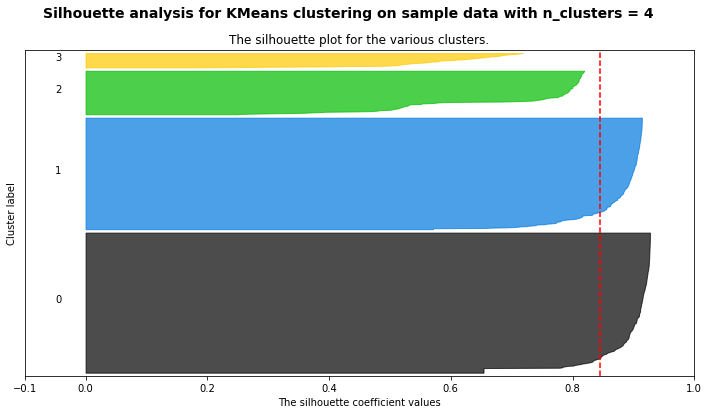

In [39]:
get_silhouette_plot(X, 4)

In [40]:
X['cluster'] = labels_map

In [41]:
%matplotlib widget

Text(0.5, 0, '$H_{s,proR}$')

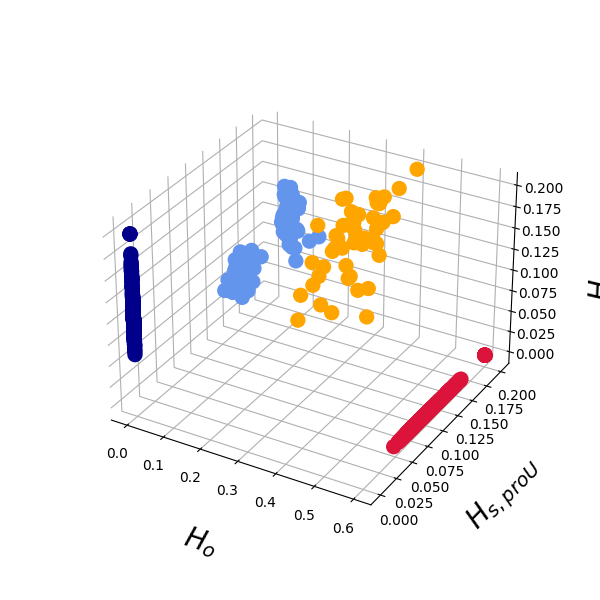

In [42]:
cluster_1_baselines = X[X['cluster']==0]
cluster_2_baselines = X[X['cluster']==1]
cluster_3_baselines = X[X['cluster']==2]
cluster_4_baselines = X[X['cluster']==3]


fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection='3d')
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))


ax.scatter(cluster_1_baselines['x_final'], cluster_1_baselines['y_pro_final'], cluster_1_baselines['y_anti_final'], marker ='o', c='crimson', s= 100, alpha=1)
ax.scatter(cluster_2_baselines['x_final'], cluster_2_baselines['y_pro_final'], cluster_2_baselines['y_anti_final'], marker ='o', c='darkblue', s= 100, alpha=1)
ax.scatter(cluster_3_baselines['x_final'], cluster_3_baselines['y_pro_final'], cluster_3_baselines['y_anti_final'], marker ='o', c='cornflowerblue', s= 100, alpha=1)
ax.scatter(cluster_4_baselines['x_final'], cluster_4_baselines['y_pro_final'], cluster_4_baselines['y_anti_final'], marker ='o', c='orange', s= 100, alpha=1)


ax.set_xlabel(r'$H_o$', fontsize='20', labelpad=20)
ax.set_ylabel(r'$H_{s,pro}$', fontsize='20', labelpad=20)
ax.set_zlabel(r'$H_{s,anti}$', fontsize='20', labelpad=20)

ax.set_xlabel(r'$H_o$', fontsize='20', labelpad=20)
ax.set_ylabel(r'$H_{s,proU}$', fontsize='20', labelpad=20)
ax.set_zlabel(r'$H_{s,proR}$', fontsize='20', labelpad=20)

In [43]:
df_polarization_index['cluster'] = labels_map

# Characterization of identified polarization behaviors classes

## Data

In [44]:
#Liste des variables indépendantes (facteurs)
list_factors = ['RT_vaccine','prop_vaccine_RTs','frequency_weeks','nb_mentors_provax','nb_mentors_antivax','Betweenness_centrality','Closeness_centrality','PageRank']

In [45]:
complete_data = factors_data.merge(df_polarization_index[['cluster','grail']], right_index=True, left_index=True)
complete_data.head()

,RT_vaccine,prop_vaccine_RTs,frequency_weeks,nb_mentors_provax,nb_mentors_antivax,Betweenness_centrality,Closeness_centrality,PageRank,cluster,grail
S937V,1129,0.009,1.000000,2.0,9.0,0.000000,0.479304,0.001035,2,-0.735322
S964V,447,0.004,1.000000,2.0,8.0,0.008074,0.478853,0.000501,2,-0.727347
S651V,272,0.003,0.740741,0.0,8.0,0.000000,0.345893,0.000348,1,-0.836796
S568V,578,0.006,1.000000,4.0,8.0,0.000000,0.497559,0.000667,2,-0.664153
S544V,1133,0.015,1.000000,3.0,10.0,0.014707,0.497073,0.001030,2,-0.705804


## Necessary functions

In [46]:
def ols_regression_optimization(ind_var,y):
    X = sm.add_constant(ind_var, prepend=False)
    
    # Note the difference in argument order
    model = sm.OLS(y, X).fit()
    predictions = model.predict(X) # make the predictions by the model
    
    # Print out the statistics
    res = [("R_squared:", model.rsquared), ("R_squared_adjusted: ", model.rsquared_adj),
           ("F_value: ", model.fvalue), ("N_observations: ", model.nobs), 
           ("DF_model: ", model.df_model), ("DF_residuals: ", model.df_resid), 
           ("Coef: ", model.params), ("STD Err", model.bse), ("t values: ", model.tvalues), 
           ("p values", model.pvalues)]
    #print(model.summary())
    return model

In [47]:
def ols_regression(ind_var,y):

    X = sm.add_constant(ind_var, prepend=False)

    model = sm.OLS(y, X).fit()
    predictions = model.predict(X) # make the predictions by the model
    
    # Print out the statistics
    res = [("R_squared:", model.rsquared), ("R_squared_adjusted: ", model.rsquared_adj),
           ("F_value: ", model.fvalue), ("N_observations: ", model.nobs), 
           ("DF_model: ", model.df_model), ("DF_residuals: ", model.df_resid), 
           ("Coef: ", model.params), ("STD Err", model.bse), ("t values: ", model.tvalues), 
           ("p values", model.pvalues)]
    print(model.summary())

In [48]:
def optimization_OLS(df, ind_var, Y):
    factors_list = []
    R_squared_list = []
    for k in tnrange(1,len(list_factors) + 1):
        for combo in itertools.combinations(list_factors, k):
            factors_list.append(combo)
            model = ols_regression_optimization(df[list(combo)], Y)
            R_squared_list.append(model.rsquared)
    df_results = pd.DataFrame({'Factors':factors_list, 'R²':R_squared_list})
    
    # best_combination = list(df_results.sort_values(by='R²', ascending=False).head(1)['Factors'].values[0])
    # best_r_squared = df_results.sort_values(by='R²', ascending=False).head(1)['R²'].values[0]
    max_r2 = round(df_results['R²'].max(), 2)
    max_factors = df_results[df_results['R²'].round(2)==max_r2]
    max_factors = max_factors.reset_index(drop=True)

    list_combinations = []
    for i in range(max_factors.shape[0]):
        list_combinations.append(list(max_factors.loc[i,'Factors']))

    best_combination = min(list_combinations, key=len)
    best_r_squared = max_r2  
    
    print('Combinaison optimale :', best_combination, '\nNombre de facteurs :', len(best_combination), '\nR² max =', best_r_squared )
    return best_combination, df_results

In [49]:
def optim_regression(df, n_cluster, value_grail, factors, get_details=False):
    cluster = df[df['cluster']==n_cluster]
    ind_var = cluster[list_factors]
    Y = cluster[value_grail]

    best_combination, results = optimization_OLS(cluster, ind_var, Y)
    
    if get_details == True:
        ind_var_optim = cluster[best_combination]
        for i in range(1, ind_var_optim.shape[1]+1):
            ols_regression(ind_var_optim.iloc[:,:i], cluster[value_grail])

    return best_combination, results

## Power test

In [50]:
from statsmodels.stats.power import FTestAnovaPower
from statsmodels.stats.power import TTestPower

In [51]:
effect_size = 0.5
alpha = 0.05
power = 0.8

In [52]:
power = TTestPower()
n_test = power.solve_power(effect_size=0.5, power=0.8, alpha=0.05)
print('Minimum size of the sample:', math.ceil(n_test))

Minimum size of the sample: 34


In [53]:
%matplotlib inline

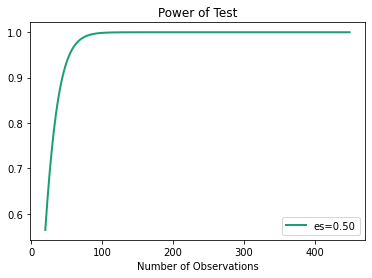

In [54]:
fig = TTestPower().plot_power(dep_var = 'nobs',
                              nobs = np.arange(20, 450),
                              effect_size = np.array([0.5]),
                              alpha = 0.05)
plt.show()

## Hierarchical regression in each identified cluster

In [55]:
ind_var = complete_data[list_factors]

In [56]:
ind_var.head()

,RT_vaccine,prop_vaccine_RTs,frequency_weeks,nb_mentors_provax,nb_mentors_antivax,Betweenness_centrality,Closeness_centrality,PageRank
S937V,1129,0.009,1.000000,2.0,9.0,0.000000,0.479304,0.001035
S964V,447,0.004,1.000000,2.0,8.0,0.008074,0.478853,0.000501
S651V,272,0.003,0.740741,0.0,8.0,0.000000,0.345893,0.000348
S568V,578,0.006,1.000000,4.0,8.0,0.000000,0.497559,0.000667
S544V,1133,0.015,1.000000,3.0,10.0,0.014707,0.497073,0.001030


In [57]:
best_combination_cluster_1, results_cluster_1 = optim_regression(complete_data, 0, 'grail', list_factors, get_details=True)
best_combination_cluster_2, results_cluster_2 = optim_regression(complete_data, 1, 'grail', list_factors, get_details=True)
best_combination_cluster_3, results_cluster_3 = optim_regression(complete_data, 2, 'grail', list_factors, get_details=True)
best_combination_cluster_4, results_cluster_4 = optim_regression(complete_data, 3, 'grail', list_factors, get_details=True)

C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_23904/1897647181.py:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for k in tnrange(1,len(list_factors) + 1):


  0%|          | 0/8 [00:00<?, ?it/s]

Combinaison optimale : ['RT_vaccine', 'nb_mentors_provax', 'Betweenness_centrality'] 
Nombre de facteurs : 3 
R² max = 0.84
                            OLS Regression Results                            
Dep. Variable:                  grail   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     21.11
Date:                Tue, 01 Aug 2023   Prob (F-statistic):           5.64e-06
Time:                        15:31:08   Log-Likelihood:                 651.79
No. Observations:                 452   AIC:                            -1300.
Df Residuals:                     450   BIC:                            -1291.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------

C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_23904/1897647181.py:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for k in tnrange(1,len(list_factors) + 1):


  0%|          | 0/8 [00:00<?, ?it/s]

Combinaison optimale : ['RT_vaccine', 'nb_mentors_antivax', 'Betweenness_centrality', 'Closeness_centrality', 'PageRank'] 
Nombre de facteurs : 5 
R² max = 0.83
                            OLS Regression Results                            
Dep. Variable:                  grail   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                  0.005046
Date:                Tue, 01 Aug 2023   Prob (F-statistic):              0.943
Time:                        15:31:09   Log-Likelihood:                 604.26
No. Observations:                 360   AIC:                            -1205.
Df Residuals:                     358   BIC:                            -1197.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      

C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_23904/1897647181.py:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for k in tnrange(1,len(list_factors) + 1):


  0%|          | 0/8 [00:00<?, ?it/s]

Combinaison optimale : ['RT_vaccine', 'prop_vaccine_RTs', 'frequency_weeks', 'nb_mentors_provax', 'nb_mentors_antivax', 'Closeness_centrality', 'PageRank'] 
Nombre de facteurs : 7 
R² max = 0.86
                            OLS Regression Results                            
Dep. Variable:                  grail   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.5005
Date:                Tue, 01 Aug 2023   Prob (F-statistic):              0.480
Time:                        15:31:11   Log-Likelihood:                 198.44
No. Observations:                 141   AIC:                            -392.9
Df Residuals:                     139   BIC:                            -387.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
               

C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_23904/1897647181.py:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for k in tnrange(1,len(list_factors) + 1):


  0%|          | 0/8 [00:00<?, ?it/s]

Combinaison optimale : ['RT_vaccine', 'frequency_weeks', 'nb_mentors_provax', 'nb_mentors_antivax', 'Betweenness_centrality', 'PageRank'] 
Nombre de facteurs : 6 
R² max = 0.81
                            OLS Regression Results                            
Dep. Variable:                  grail   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.016
Method:                 Least Squares   F-statistic:                    0.2897
Date:                Tue, 01 Aug 2023   Prob (F-statistic):              0.593
Time:                        15:31:12   Log-Likelihood:                -3.9809
No. Observations:                  47   AIC:                             11.96
Df Residuals:                      45   BIC:                             15.66
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err 